<h1 style="padding: 25px 25px; background-color: #F5B041; font-family: Sans-Serif; color:black; text-align: center">
Project: Safety Helmet Detection</h1>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Overview</h2>

Goal of the project is to detect the presence of people and safety helmets thus improving work safety.

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Table of contents</h2>

1. [Data Description](#data-description)
2. [Import modules](#import-modules)
3. [Configuration](#configuration)
4. [Data Exploration](#data-exploration)
5. [Train](#train)
6. [Test](#test)

<a id="data-description"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Data description</h2>

- The dataset is a great collection of images, since the labels are in the following format: 'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle'

- **Quick Summary**
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
    - Metadata: metadata.csv and count.csv provides information about the dataset and train-val-test count information.
    - PPE Class Map: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
    - Difficulty: This is a beginner-friendly dataset on multi-class classification, object detection, and tracking. Annotations are in YoloV8 format. The splits are given in the dataset folder itself with metadata, so anyone can use this data to run models and produce results.


<a id="import-modules"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Import modules</h2>

In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 56.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


<a id="configuration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Configuration</h2>

In [4]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

W&B disabled.


In [5]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define directories in Google Drive
INPUT_DIR = '/content/drive/MyDrive/construction-site-safety-dataset/css-data'
WORK_DIR = '/content/drive/MyDrive/construction-site-safety-dataset/working'

# Ensure directories exist (create them if they don't)
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Input directory is set to: {INPUT_DIR}")
print(f"Working directory is set to: {WORK_DIR}")


Mounted at /content/drive
Input directory is set to: /content/drive/MyDrive/construction-site-safety-dataset/css-data
Working directory is set to: /content/drive/MyDrive/construction-site-safety-dataset/working


<a id="Data Exploration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Data Exploration</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Create data YAML file</b></h4>

In [6]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [7]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check class balance</b></h4>

In [8]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

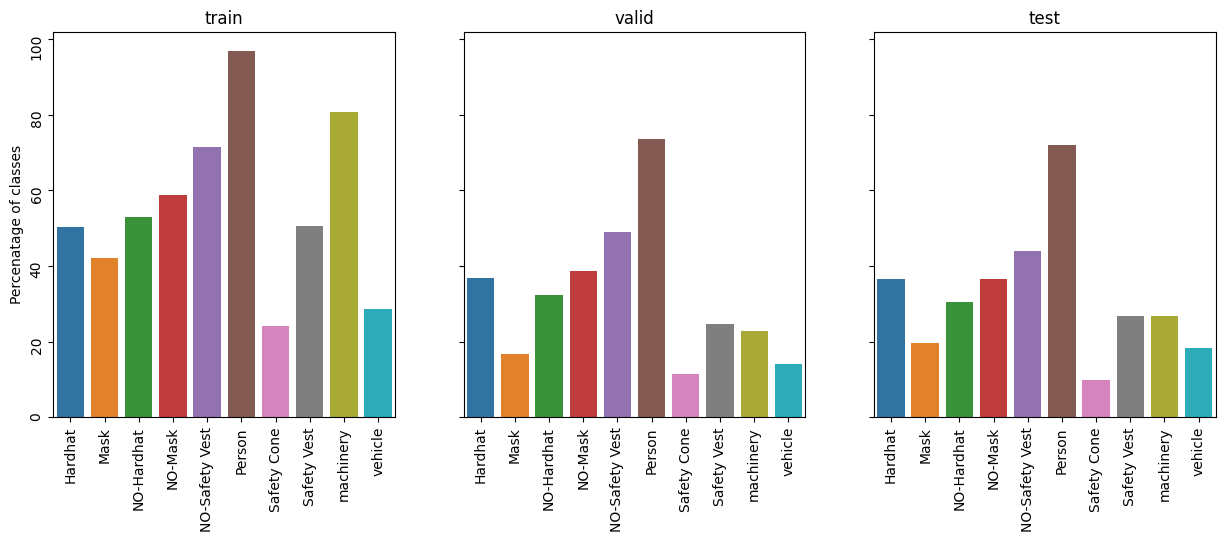

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

- There is imbalance in classes


- Overall class distribution between train, validation and test sets are similar, although validation and test sets have significantly lower percentage of `machinery` class

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check image sizes</b></h4>

In [10]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


- All images have size `640x640`

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check dataset sizes</b></h4>

In [11]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



<a id="train"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Train</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Arguments for training</b></h4>

- **task**: preform `detect`, `segment` or `classify`
- **imgsz**: define input image size
- **batch**: determine batch size
- **epochs**: define the number of training epochs. (Note: often, 3000+ are common here!)
- **data**: set the path to our yaml file
- **mode**: mode - `train`, `val` or `predict`
- **model**: model to use (could be pre-trained)
- **name**: result names

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Load model<b></h4>

- Load `pre-trained` YOLO-nano model

In [12]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 362MB/s]


<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Train</b></h4>

In [13]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    print(f"Device: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available, using CPU")


GPU is available
Device: Tesla T4


In [14]:
model.train(
    data=os.path.join(WORK_DIR, 'data.yaml'),  # Path to the dataset YAML file
    task='detect',                             # Detection task
    imgsz=640,                                 # Image size
    epochs=30,                                 # Number of epochs
    batch=32,                                  # Batch size
    mode='train',                              # Training mode
    name='yolov8n_v1_train',                   # Model training name
    verbose=True,
    device=0                                   # Enable detailed logs
)


Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/construction-site-safety-dataset/working/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 391MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/construction-site-safety-dataset/css-data/train/labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/construction-site-safety-dataset/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/construction-site-safety-dataset/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/construction-site-safety-dataset/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_v1_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_v1_train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.37G      1.391      2.994      1.493        253        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.73s/it]

                   all        114        697      0.505      0.304      0.331      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.39G      1.303      1.879       1.44        245        640: 100%|██████████| 82/82 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        697      0.531      0.379      0.408      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.39G       1.25      1.658      1.407        359        640: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        697      0.671      0.439       0.47      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.23G      1.215      1.567      1.383        246        640: 100%|██████████| 82/82 [01:00<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        697       0.61      0.439       0.47      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.58G      1.188      1.481      1.356        265        640: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        114        697      0.601       0.46      0.465      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.69G       1.18      1.414      1.339        351        640: 100%|██████████| 82/82 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        697      0.665      0.507      0.545      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.45G      1.148      1.354      1.322        291        640: 100%|██████████| 82/82 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        697      0.663      0.497      0.553      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.95G      1.133      1.308      1.304        323        640: 100%|██████████| 82/82 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        697      0.727      0.469      0.549      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.06G      1.112      1.261      1.285        311        640: 100%|██████████| 82/82 [01:01<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all        114        697      0.681      0.566      0.604      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.12G      1.093      1.217      1.276        227        640: 100%|██████████| 82/82 [00:59<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        697      0.772      0.587       0.64      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.61G      1.086      1.188      1.265        284        640: 100%|██████████| 82/82 [01:00<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all        114        697       0.77       0.59      0.648      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.27G      1.073      1.155      1.256        164        640: 100%|██████████| 82/82 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        697      0.702      0.568      0.609      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.08G      1.073      1.124      1.249        288        640: 100%|██████████| 82/82 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


                   all        114        697       0.77      0.605      0.661      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.26G      1.045      1.108      1.238        337        640: 100%|██████████| 82/82 [01:00<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        114        697      0.741      0.594      0.654      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       6.1G      1.037      1.083      1.232        305        640: 100%|██████████| 82/82 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


                   all        114        697      0.789      0.632      0.695      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.08G      1.024      1.058      1.223        246        640: 100%|██████████| 82/82 [01:01<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        114        697       0.81      0.645        0.7      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.92G      1.018       1.04      1.217        310        640: 100%|██████████| 82/82 [00:59<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        697      0.771      0.638      0.694      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         6G      1.011      1.013      1.211        257        640: 100%|██████████| 82/82 [01:02<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        697      0.789      0.632      0.688      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.19G      1.004      1.005      1.202        286        640: 100%|██████████| 82/82 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        114        697       0.82      0.641        0.7      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.06G     0.9789     0.9687      1.189        303        640: 100%|██████████| 82/82 [01:02<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        697      0.844      0.636      0.715      0.373


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.18G      1.016     0.9244       1.21        231        640: 100%|██████████| 82/82 [01:00<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

                   all        114        697       0.79      0.667       0.72      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.38G     0.9966     0.8767        1.2        207        640: 100%|██████████| 82/82 [00:58<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        114        697      0.807      0.662      0.716      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.54G     0.9793      0.851       1.19        183        640: 100%|██████████| 82/82 [00:57<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        114        697      0.843      0.665      0.727      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.15G     0.9689     0.8332      1.177        140        640: 100%|██████████| 82/82 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all        114        697      0.857      0.651      0.729      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.85G     0.9554     0.8119      1.172        138        640: 100%|██████████| 82/82 [01:00<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

                   all        114        697      0.872       0.65      0.735      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.93G     0.9339     0.7911      1.156        155        640: 100%|██████████| 82/82 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        114        697      0.851      0.658       0.74      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.14G     0.9308     0.7852      1.154        219        640: 100%|██████████| 82/82 [00:58<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]

                   all        114        697      0.848       0.67      0.746      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.43G     0.9152     0.7672       1.15        188        640: 100%|██████████| 82/82 [00:59<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        114        697      0.835      0.683      0.742      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.59G     0.9056     0.7577       1.14        164        640: 100%|██████████| 82/82 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        114        697      0.858      0.665      0.748      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.89G     0.8897     0.7395       1.13        215        640: 100%|██████████| 82/82 [00:58<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all        114        697      0.861       0.68      0.753      0.434



30 epochs completed in 0.546 hours.
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_v1_train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


                   all        114        697      0.848      0.671      0.746      0.437
               Hardhat         42         79      0.921      0.734      0.824      0.517
                  Mask         19         21      0.911       0.81      0.853      0.568
            NO-Hardhat         37         69      0.914      0.536      0.627      0.315
               NO-Mask         44         74      0.822      0.473       0.57      0.257
        NO-Safety Vest         56        106      0.829      0.595      0.709      0.388
                Person         84        166      0.886      0.693      0.796      0.472
           Safety Cone         13         44      0.854      0.841      0.867      0.452
           Safety Vest         28         41      0.881      0.725      0.859      0.494
             machinery         26         55      0.905      0.871      0.898      0.618
               vehicle         16         42      0.556      0.429      0.455      0.287
Speed: 0.3ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e5ba56eff90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

<a id="test"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Test</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Select best model</b></h4>

In [15]:
model = YOLO('runs/detect/yolov8n_v1_train/weights/best.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Make predicitons on test set</b></h4>

In [16]:
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)


image 1/82 /content/drive/MyDrive/construction-site-safety-dataset/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 2 NO-Safety Vests, 1 Person, 18.6ms
image 2/82 /content/drive/MyDrive/construction-site-safety-dataset/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 3 Hardhats, 2 NO-Masks, 3 Persons, 12.3ms
image 3/82 /content/drive/MyDrive/construction-site-safety-dataset/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 1 NO-Mask, 3 NO-Safety Vests, 3 Persons, 9.3ms
image 4/82 /content/drive/MyDrive/construction-site-safety-dataset/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 9.4ms
image 5/82 /content/drive/MyDrive/construction-site-safety-dataset/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 5 NO-Safety Vests, 6 Per

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Show prediction results</b></h4>

['/content/runs/detect/predict2/youtube-34_jpg.rf.03eacc444bae3c5caa3fef5c736c3e40.jpg', '/content/runs/detect/predict2/2008_008519_jpg.rf.1798c8eed7de04399a0e7e297b4b4c9e.jpg', '/content/runs/detect/predict2/thumbnail-ba5c72edb320b49a69e86b05775c49b2-scaled-1_jpeg_jpg.rf.3bb460e284098219861b894fb0db13d5.jpg', '/content/runs/detect/predict2/autox3_mp4-65_jpg.rf.d933ce48947fa9bdb55dc702a0879ac9.jpg', '/content/runs/detect/predict2/construction-639-_jpg.rf.7db2168ad99f643f7e3070733387e3bb.jpg']


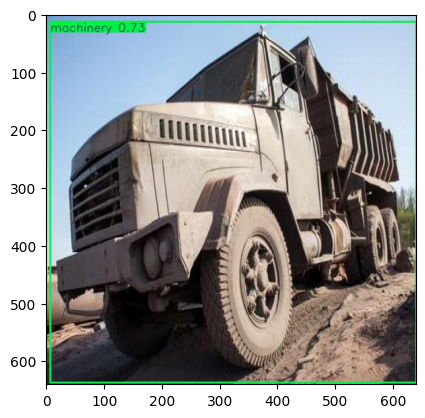

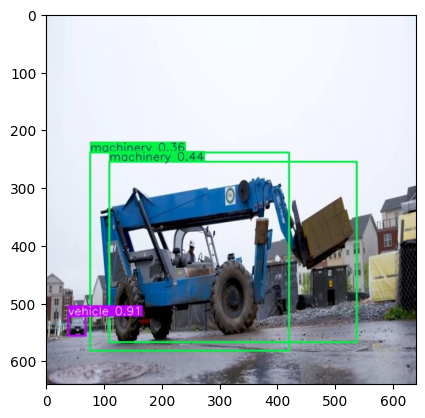

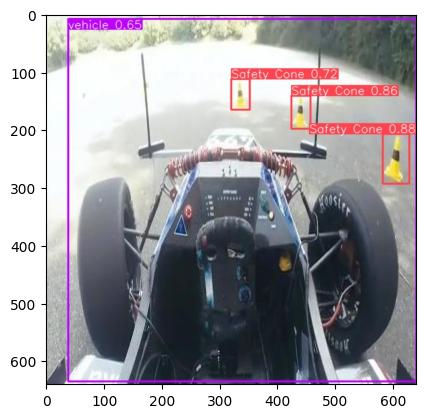

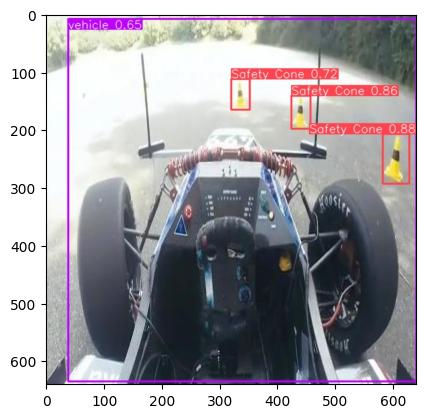

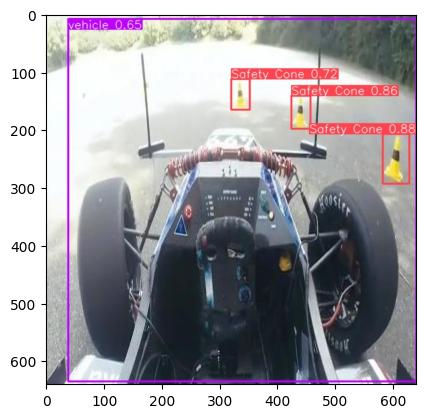

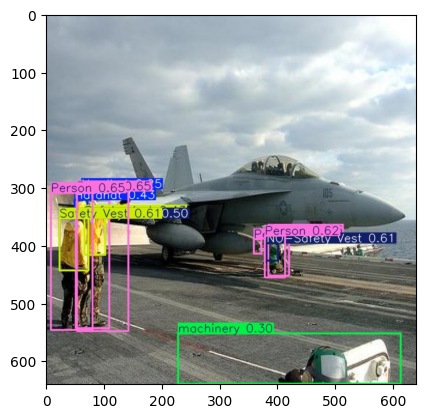

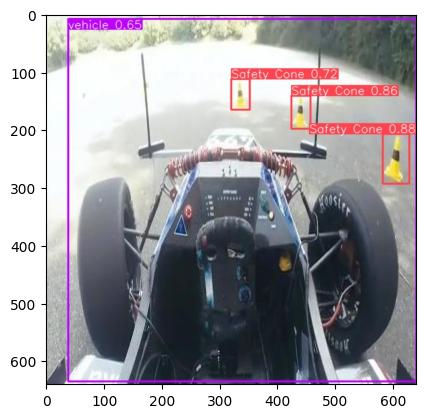

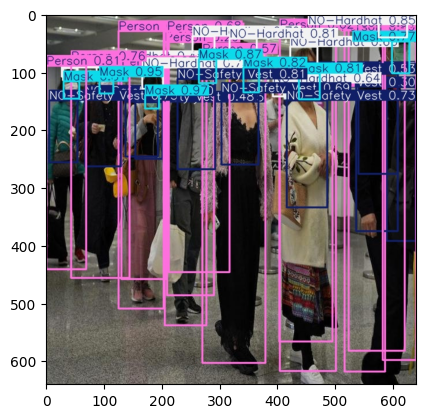

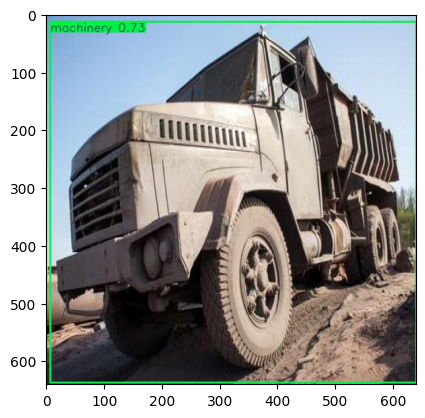

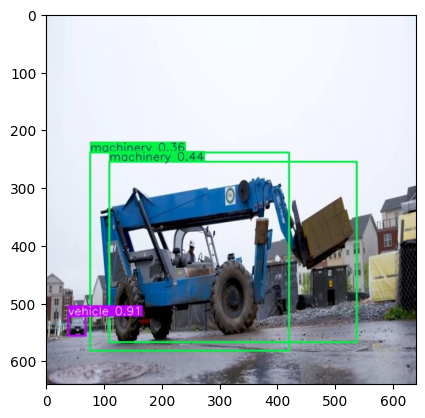

In [27]:
%matplotlib inline

predicitions = glob.glob(os.path.join(WORK_DIR, '/content/runs/detect/predict2', '*'))
print(predicitions)
n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()